## 1. Setup and Retrieving Data

#### 1.1: Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

You should consider upgrading via the 'Z:\Workspace\PythonProjects\facedetect\Scripts\python.exe -m pip install --upgrade pip' command.


### 1.2: Collect Images Using OpenCV

In [2]:
# Import necessary libraries
import os
import time
# gives a unique identifier 
import uuid
import cv2

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 60

In [6]:
# establish connection to video camera
cap = cv2.VideoCapture(0)

# loop through range of images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    # read from the capture device
    # capture the frame and allow us to write the file name
    ret, frame = cap.read()
    
    # defines the name of the file
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    
    # write out name of the frame using unique name
    cv2.imwrite(imgname, frame)
    # show to me
    cv2.imshow('frame', frame)
    time.sleep(0.5)
   
    # cv2 break code to break outof the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3: Annotate Images with LabelMe 

In [7]:
!labelme

## 2. Review Dataset and Build Image Loading Function 

#### 2.1: Import TF and Deps

In [8]:
# used to import data pipeline/build the model
import tensorflow as tf
# able to load in the labeled images
import json
import numpy as np
from matplotlib import pyplot as plt

#### 2.2: Limit GPU Memory Growth

In [9]:
# Helps with avoiding Out of Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[]

#### 2.3: Load Image Into TF Data Pipeline


In [11]:
# goes into the data/images and looks for anything with a .jpg extension
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [12]:
images.as_numpy_iterator().next()

b'data\\images\\ea83344d-8fc4-11ed-8c38-0cdd243d24bb.jpg'

In [13]:
# passes through the file path
def load_image(x):
    # tensorflow code that actually reads the image
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [14]:
images = images.map(load_image)

In [15]:
# visualizses the imaages in an array format
images.as_numpy_iterator().next()

array([[[ 48,  52,  99],
        [ 48,  52,  99],
        [ 48,  52, 100],
        ...,
        [  7,  14,  20],
        [  5,  16,  12],
        [  4,  15,   7]],

       [[ 48,  52,  99],
        [ 48,  52,  99],
        [ 48,  52, 100],
        ...,
        [  4,  12,  15],
        [  3,  14,  10],
        [  3,  15,   5]],

       [[ 48,  50,  99],
        [ 48,  50,  99],
        [ 48,  50, 101],
        ...,
        [  0,  10,  11],
        [  2,  13,   7],
        [  3,  15,   3]],

       ...,

       [[  8,   9,  27],
        [  7,  10,  27],
        [  8,  11,  28],
        ...,
        [  7,   5,   6],
        [  7,   5,   8],
        [  7,   5,   8]],

       [[  9,  12,  31],
        [  9,  12,  31],
        [ 10,  13,  32],
        ...,
        [  6,   6,   8],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[  9,  12,  31],
        [ 10,  13,  32],
        [  9,  14,  34],
        ...,
        [  6,   6,   8],
        [  6,   6,   6],
        [  6,   6,   6]]

In [16]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

#### 2.4 View Raw Images with Matplotlib

In [17]:
# visualize images in Matplotlib
# returns the number of values in the batch
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
# gets the next batch of images
plot_images = image_generator.next()

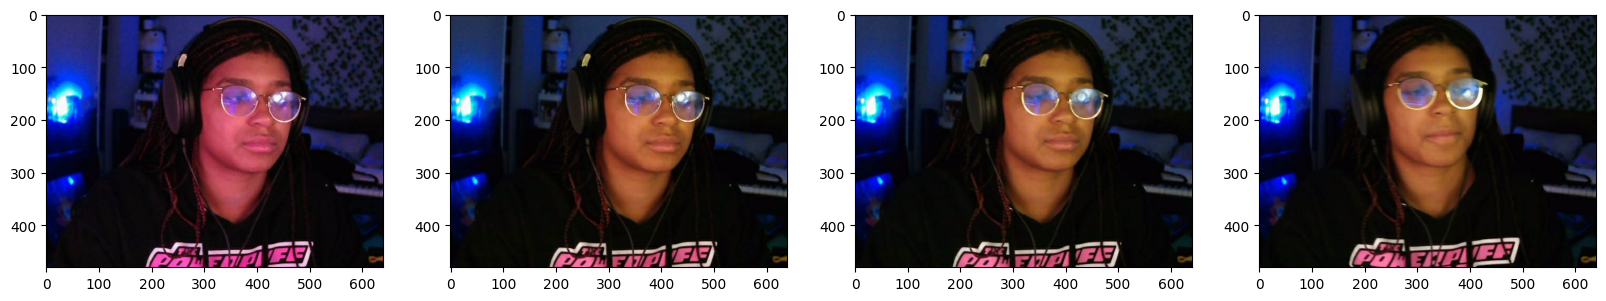

In [19]:
#Loop through and visualize the images
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data

#### 3.1: MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

#### 3.2: Move the matching labels

In [20]:
# looks for specific folder names
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder ,'images')):
        # looks for the labelled images and places them in the correct folder
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Timestamp: 51:39

## 4. Apply Images Augmentation on Images and Labels using Albumentations

#### 4.1: Setup Albumentations Transform Pipeline

In [75]:
#import albumentations!
import albumentations as alb

In [76]:
# holds se
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
            alb.HorizontalFlip(p=0.5), 
            alb.RandomBrightnessContrast(p=0.2), 
            alb.RandomGamma(p=0.2), 
            alb.RGBShift(p=0.2), 
            alb.VerticalFlip(p=0.5)], 
            bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

#### 4.2: Load a Test Image and Annotations with OpenCV and JSON

In [77]:
img = cv2.imread(os.path.join('data', 'train','images','ebc57bc7-8fc4-11ed-89c5-0cdd243d24bb.jpg'))

In [78]:
with open(os.path.join('data','train','labels', 'ebc57bc7-8fc4-11ed-89c5-0cdd243d24bb.json'), 'r') as f:
    # creates a label which is a dictionary
    label = json.load(f)

#### 4.3: Extract Coordinates and Rescale to Match Image Resolution

In [79]:
# takes the label and places them in a simple vector
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

# format is 
    # x1 , y1, x2, y2

In [80]:
# divides the points by the size of the image based on the albumentations format
coords = list(np.divide(coords, [640 ,480 ,640 ,480 ]))

In [81]:
coords

[0.23680218446601944,
 0.08838996763754046,
 0.5932949029126213,
 0.6041666666666666]

#### 4.4: Apply Augmentations and View Results 

In [69]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])

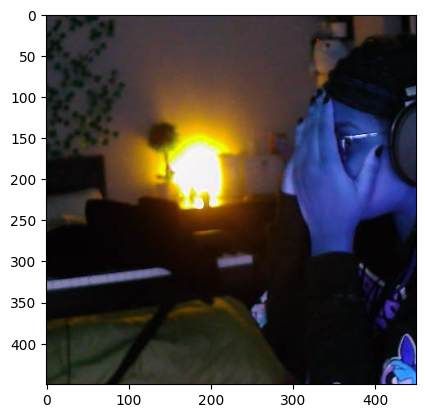

In [82]:
cv2.rectangle(augmented['image'], 
    tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
    (255,0,0),2)
    
plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

#### 5.1 Run Augemntation Pipeline

In [84]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(e)

#### 5.2 Load Augmented Images to Tensorflow Dataset

In [85]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [86]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [87]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [88]:
train_images.as_numpy_iterator().next()

array([[[0.01041667, 0.03664216, 0.24993873],
        [0.02009804, 0.02977941, 0.04099265],
        [0.02383578, 0.0153799 , 0.06991421],
        ...,
        [0.10067402, 0.11519608, 0.24368873],
        [0.11390931, 0.1286152 , 0.25165442],
        [0.13382353, 0.13235295, 0.24117647]],

       [[0.        , 0.03186275, 0.2514706 ],
        [0.01660539, 0.00428922, 0.03026961],
        [0.01305147, 0.03082108, 0.0538603 ],
        ...,
        [0.12015931, 0.1471201 , 0.25637254],
        [0.08290441, 0.1098652 , 0.21685049],
        [0.0598652 , 0.08192402, 0.15643382]],

       [[0.        , 0.02775735, 0.23039216],
        [0.02745098, 0.00833333, 0.02156863],
        [0.03492647, 0.04797794, 0.10931373],
        ...,
        [0.09607843, 0.11911765, 0.1764706 ],
        [0.10300245, 0.12653187, 0.17371324],
        [0.01936275, 0.04926471, 0.06807598]],

       ...,

       [[0.97990197, 0.45520833, 0.625     ],
        [0.998652  , 0.46746323, 0.63884807],
        [0.8523897 , 0

## 6. Prepare Labels


#### 6.1: Build Label Loading Function

In [89]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

#### 6.2: Load Labels to Tensorflow Dataset

In [90]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [91]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [92]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [93]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.     , 0.08765, 0.4526 , 0.6377 ], dtype=float16))

## 7. Combine Label and image Samples

#### 7.1: Check Partition Lengths

In [94]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1200, 1200, 1200, 1200, 1200, 1200)

#### 7.2: Create Final Datasets (Images/Labels)

In [95]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [97]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [98]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

#### 7.3: View Images and Annotations

In [99]:
data_samples = train.as_numpy_iterator()

In [100]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


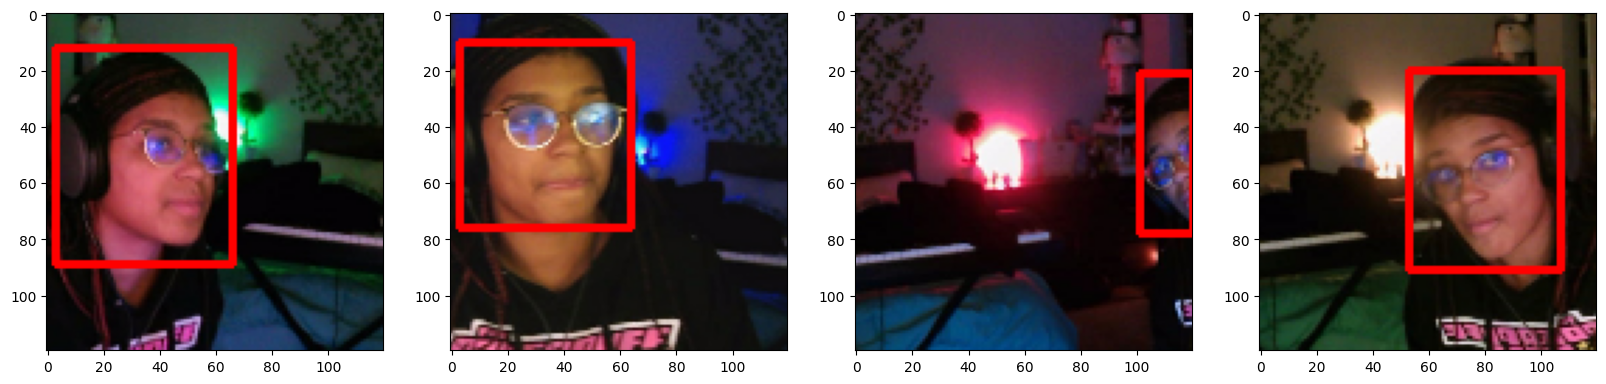

In [101]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API

#### 8.1: Import Layers and Base Network

In [103]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### 8.2: Download VGG16

In [104]:
vgg = VGG16(include_top = False)

58889256/58889256 [==============================] - 15s 0us/step


In [105]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### 8.3: Build instance of the Network


In [106]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

#### 8.4: Test Out the Neural Network

In [107]:
facetracker = build_model()

In [108]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [109]:
X, y = train.as_numpy_iterator().next()

In [110]:
X.shape

(8, 120, 120, 3)

In [111]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 418ms/step


In [112]:
classes, coords

(array([[0.4592318 ],
        [0.4427999 ],
        [0.42338794],
        [0.48686787],
        [0.4640688 ],
        [0.46097666],
        [0.452457  ],
        [0.45419505]], dtype=float32),
 array([[0.547589  , 0.51762956, 0.5263803 , 0.44855648],
        [0.5241686 , 0.51051414, 0.49397802, 0.45503443],
        [0.539369  , 0.5318513 , 0.46096268, 0.33001468],
        [0.54294574, 0.5328478 , 0.5496175 , 0.49417898],
        [0.5275617 , 0.48512107, 0.5575995 , 0.45343944],
        [0.58946097, 0.5670153 , 0.5553826 , 0.3260739 ],
        [0.55869585, 0.49477395, 0.5491052 , 0.50477594],
        [0.5387437 , 0.48758456, 0.51826125, 0.48796847]], dtype=float32))

## 9. Define Losses and Optimizers

#### 9.1: Define Optimizer and LR

In [113]:
batches_per_epoch = len(train)
lr_decay = (1/0.75 - 1)/batches_per_epoch

In [114]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

#### 9.2: Create Localization Loss and Classification Loss

In [115]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [116]:
classLoss = tf.keras.losses.BinaryCrossentropy()
regressLoss = localization_loss

#### 9.3: Test Out Loss Metrics

In [117]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2059464>

In [118]:
classLoss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7156862>

In [119]:
regressLoss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.2059464>

## 10. Train Neural Network

#### 10.1: Create Custom Model Class


In [121]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [122]:
model = FaceTracker(facetracker)

In [123]:
model.compile(opt, classLoss, regressLoss)

#### 10.2: Train

In [124]:
logdir = 'logs'

In [125]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [126]:
hist = model.fit(train, epochs = 10, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/10
150/150 [==============================] - 179s 1s/step - total_loss: 0.7730 - class_loss: 0.2085 - regress_loss: 0.6688 - val_total_loss: 0.8854 - val_class_loss: 0.6732 - val_regress_loss: 0.5488
Epoch 2/10
150/150 [==============================] - 169s 1s/step - total_loss: 0.2128 - class_loss: 0.0659 - regress_loss: 0.1799 - val_total_loss: 0.1531 - val_class_loss: 2.4297e-04 - val_regress_loss: 0.1530
Epoch 3/10
150/150 [==============================] - 172s 1s/step - total_loss: 0.1581 - class_loss: 0.0605 - regress_loss: 0.1279 - val_total_loss: 0.1349 - val_class_loss: 0.0019 - val_regress_loss: 0.1340
Epoch 4/10
150/150 [==============================] - 174s 1s/step - total_loss: 0.0852 - class_loss: 0.0364 - regress_loss: 0.0670 - val_total_loss: 0.0597 - val_class_loss: 0.0122 - val_regress_loss: 0.0536
Epoch 5/10
150/150 [==============================] - 177s 1s/step - total_loss: 0.0480 - class_loss: 0.0185 - regress_loss: 0.0388 - val_total_loss: 0.0773 - v

#### 10.3: Plot Performance

In [127]:
hist.history

{'total_loss': [0.1375785917043686,
  0.039660412818193436,
  0.030047431588172913,
  0.37748003005981445,
  0.032497577369213104,
  0.018528753891587257,
  0.006772602442651987,
  0.017100734636187553,
  0.0062333946116268635,
  0.006547160912305117],
 'class_loss': [0.01449529454112053,
  0.0073589445091784,
  0.0011581841390579939,
  0.3478095233440399,
  0.0020499229431152344,
  0.0008422306273132563,
  0.0006015592953190207,
  0.0003204545355401933,
  0.0001965902920346707,
  0.00019018436432816088],
 'regress_loss': [0.13033095002174377,
  0.035980939865112305,
  0.029468338936567307,
  0.2035752534866333,
  0.03147261589765549,
  0.018107637763023376,
  0.0064718229696154594,
  0.016940508037805557,
  0.006135099567472935,
  0.0064520686864852905],
 'val_total_loss': [0.8854213953018188,
  0.15308518707752228,
  0.13494130969047546,
  0.05966503173112869,
  0.07727707922458649,
  3.907349109649658,
  0.04512743651866913,
  0.19371254742145538,
  0.18737152218818665,
  0.98308080

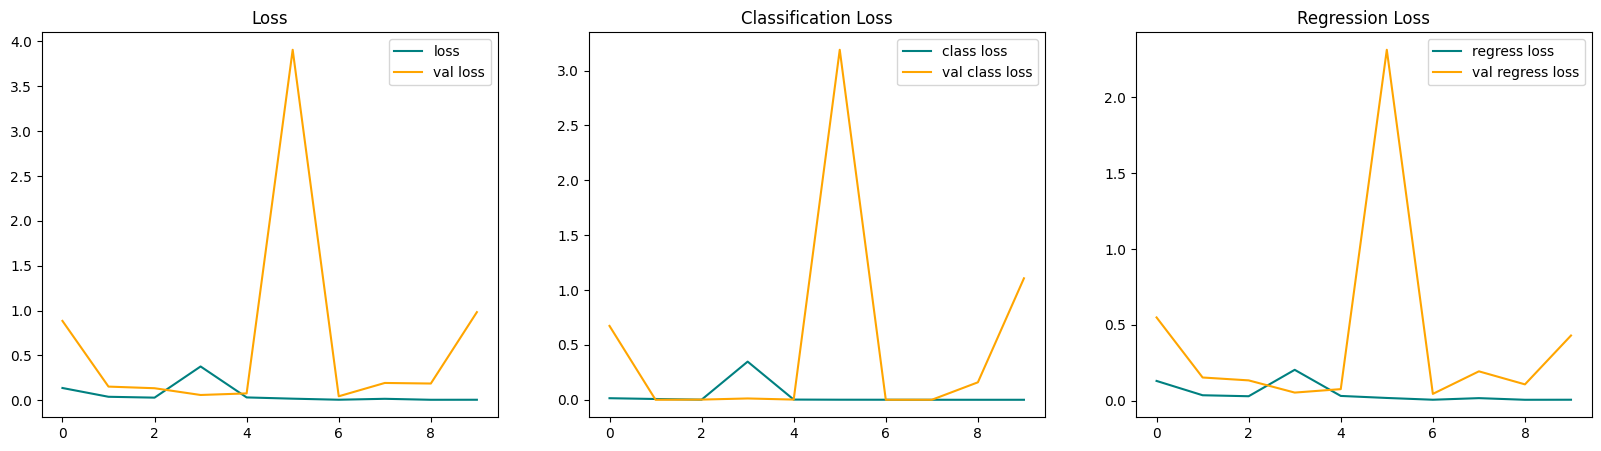

In [128]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

#### 11.1: Make Predictions on Test Set

In [129]:
test_data = test.as_numpy_iterator()

In [130]:
test_sample = test_data.next()

In [131]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 254ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


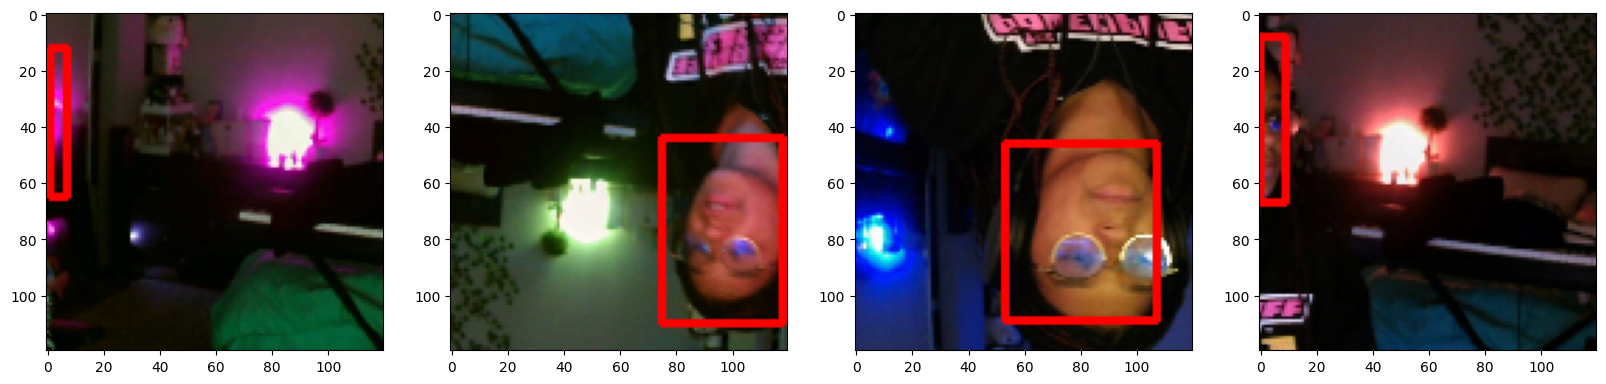

In [132]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

#### 11.2: Save the Model

In [133]:
from tensorflow.keras.models import load_model

In [134]:
facetracker.save('facetracker.h5')

In [135]:
facetracker = load_model('facetracker.h5')

#### 11.3 Real Time Detection


In [138]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 61ms/step


KeyboardInterrupt: 

: 